In [1]:
import re
from sympy.parsing.latex import parse_latex
from sympy import Basic
import sympy
import numpy as np
from pprint import pprint
from transformers import AutoTokenizer
import random
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/opt/homebrew/Caskroom/miniconda/base/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K")

In [3]:
train_ds = ds['train'][:10000]

In [4]:

NUM_SAMPLES = 1000
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES)

In [5]:
train_ds_qs = train_ds['question']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']

# Preliminary tasks

## Briefly describe the data

In [ ]:
# TODO

## Parsing

### Notes
- [x] Questions have different latex sytanx (`[`, `(`, `$`)
- [] How do we tokenize the latex formula?
  - [x] `hybrid_tokenize` with word lenght tokens
  - [x] pretrained tokenizers from hf
  - [] https://github.com/google/sentencepiece

In [6]:
train_ds_qs = np.array(train_ds_qs)
train_ds_qs = train_ds_qs[random_indices]

reason_1_ds = np.array(reason_1_ds)
reason_1_ds = reason_1_ds[random_indices]

reason_2_ds = np.array(reason_2_ds)
reason_2_ds = reason_2_ds[random_indices]

reason_3_ds = np.array(reason_3_ds)
reason_3_ds = reason_3_ds[random_indices]

### Initial investigation on sympy

In [ ]:

def extract_latex_bracket_content(text):
    patterns = [
        r'\\\[(.*?)\\\]',  # \[ ... \]
        r'\\\((.*?)\\\)',  # \( ... \)
        r'\$(.*?)\$',       # $ ... $
    ]
    # Combine patterns into one
    combined_pattern = '|'.join(patterns)
    #matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    #formulas = [next(filter(None, tup)) for tup in matches]
    matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    formulas = []
    for tup in matches:
        non_empty = list(filter(None, tup))
        if non_empty:
            formulas.append(non_empty[0])
    # Use a counter to number the placeholders
    def replacer(match, counter=[1]):
        placeholder = "{" + str(counter[0]-1) + "}"
        counter[0] += 1
        return placeholder
    new_text = re.sub(combined_pattern, replacer, text)
    return new_text, formulas

parsed_indices = []
parsed_text = []
parsed_formulas = []
for i in range(len(train_ds_qs)):
    d = train_ds_qs[i]
    #print("original input:", d)
    text, formulas = extract_latex_bracket_content(d)
    #print("parsed text: ", text, "\nequations: ", formulas)
    formulas_sympy = []
    num_parsed = 0
    for expr in formulas:
        try:
            parsed = parse_latex(expr)
            formulas_sympy.append(parsed)
            num_parsed += 1
        except Exception as e:
            pass
            #print("Could not parse:", e)
            #print(parsed)
    if num_parsed == len(formulas):
        parsed_indices.append(i)
        parsed_text.append(text)
        parsed_formulas.append(formulas_sympy)
print("correctly parsed", len(parsed_indices), "inputs over", len(train_ds_qs))

### Hybrid tokenizer

In [ ]:
def print_sympy_tree(expr, indent=0):
    print('  ' * indent + str(expr.func))
    for arg in expr.args:
        print_sympy_tree(arg, indent + 1)

# --- Parse LaTeX into sympy then walk the expression tree ---
def flatten_sympy_expr(expr: Basic):
    tokens = []

    def walk(node):
        if isinstance(node, Basic):
            args_len = len(node.args)
            args = node.args
            # If only 1 we build the output as operator + walk(operand)
            if args_len == 1:
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                walk(args[0])
            # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
            elif args_len == 2:
                walk(args[0])
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                walk(args[1])
            # If no operands are found we just add self
            elif args_len == 0:
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
            # If there are multiple operands (> 2) we add them all after the operator
            else:
                if isinstance(node, (sympy.Limit, sympy.Integral)):
                    args = reversed(args)
                if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                    tokens.append(str(node))
                else:
                    tokens.append(node.func.__name__)
                for arg in args:
                    walk(arg)
        else:
            raise RuntimeError("not sympy Basic object")
    
    walk(expr)
    return tokens

# --- Main tokenization function ---
def hybrid_tokenize(text):
    math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
    parts = re.split(math_pattern, text, flags=re.DOTALL)

    final_tokens = []
    is_erorr = False
    for part in parts:
        if re.match(math_pattern, part, flags=re.DOTALL):
            # Clean math delimiters
            clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
            try:
                parsed = parse_latex(clean)
                math_tokens = flatten_sympy_expr(parsed)
                final_tokens.extend(math_tokens)
            except Exception as e:
                is_erorr = True
                final_tokens.extend(clean.split(' '))
        else:
            final_tokens.extend(re.findall(r'\b\w+\b', part))
    return is_erorr, final_tokens



In [ ]:

parsed_inputs = []
not_parsed_inputs = []
for d in train_ds_qs:
    error, tokens = hybrid_tokenize(d)
    if not error:
        parsed_inputs.append(tokens)
    else:
        not_parsed_inputs.append(tokens)


print("correctly parsed", len(parsed_inputs), "inputs over", len(train_ds_qs))
print("not parsed", len(not_parsed_inputs), "inputs over", len(train_ds_qs))


In [ ]:
not_parsed_inputs[:1]

### Tokenization with different pretrained

In order to fit all the qs and reasonings we need a large context window tokenizer. We found that 4k of longformer is enough (for random 1000 samples).

In [7]:
model_name = "allenai/longformer-base-4096"
#model_name = "lmsys/longchat-13b-16k"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
token_ids = []
tokens = []
for d in train_ds_qs:
	#tokens = tokenizer.tokenize(d)
    tokens.append(tokenizer.tokenize(d))
    token_ids.append(tokenizer.encode(d))

In [12]:
r1_tokens_id = []
r1_tokens = []
for d in reason_1_ds:
	#tokens = tokenizer.tokenize(d)
    r1_tokens.append(tokenizer.tokenize(d))
    r1_tokens_id.append(tokenizer.encode(d))

In [ ]:
r2_tokens_id = []
r2_tokens = []
for d in reason_2_ds:
	#tokens = tokenizer.tokenize(d)
    r2_tokens.append(tokenizer.tokenize(d))
    r2_tokens_id.append(tokenizer.encode(d))

In [ ]:
r3_tokens_id = []
r3_tokens = []
for d in reason_3_ds:
	#tokens = tokenizer.tokenize(d)
    r3_tokens.append(tokenizer.tokenize(d))
    r3_tokens_id.append(tokenizer.encode(d))

In [ ]:
for i in range(3):
    print(tokens[i])
    print(token_ids[i])
    print(len(token_ids[i]))
    print(len(tokens[i]))


## Perform cluster analysis on questions field

## Perform cluster analysis on questions field

In [ ]:
# TODO

## Perform document index on different fields

In [ ]:
# pip install -q python-terrier==0.11.0 #now there is another version but we don't use it

In [ ]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@11/11.0.21/libexec/openjdk.jdk/Contents/Home"
os.environ["JVM_PATH"] = "/opt/homebrew/Cellar/openjdk@11/11.0.26/libexec/openjdk.jdk/Contents/Home/lib/server/libjvm.dylib"

In [ ]:
column_names = train_ds.column_names
print(column_names)

# 2. Initialize PyTerrier (only once)
import pyterrier as pt

# google colab
#if not pt.started():
#  pt.init()

# vs code in mac
if not pt.java.started():
    pt.init()

### Finding "quadratic form" in 'question'

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(train_ds),
    fields=('question',),
    meta=('docno', 'question')  # store docno + question in the metadata
)

# 5. Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results = tfidf.search("quadratic form")
print(results.head(6))

### Perform a 'question' search in only documents with x difficulty

In [ ]:
# Imposto difficulty = 0.0
filtered_ds = [ex for ex in train_ds if float(ex['difficulty']) == 0.0]

# Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in enumerate(ds):
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(filtered_ds),
    fields=('question',),
    meta=('docno', 'question')
)

# Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
query = "quadratic form"
query1 = "quadratic form optimization minimize" #puoi mettere piu parole e funziona
results = tfidf.search(query)
print(results.head(6))

### Finding 'quadratic form' in more fields (NON RIUSCITO)

## Generate embeddings and analyze them

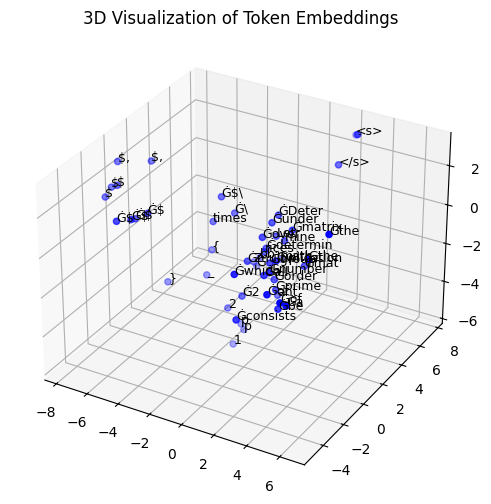

In [ ]:
# Example token IDs (replace with your token IDs)
token_id = token_ids[45]

model = AutoModel.from_pretrained(model_name)

# Convert token IDs to embeddings
input_ids = torch.tensor([token_id])  # Add batch dimension
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, hidden_dim)

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Visualize in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c='blue', marker='o')

# Annotate tokens
tokens = tokenizer.convert_ids_to_tokens(token_id)
for i, token in enumerate(tokens):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], token, fontsize=9)

ax.set_title("3D Visualization of Token Embeddings")
plt.show()

# Training

## M1C: Base model (topic classification)

## M1R: Base model (difficulty regression)

## M1S: Base model (short answer)

## M2: Introduce reasoning

## Comparisons